# Introduction

This notebook contains much of the code used to generate graphs in my presentation as well as extra examples and test code

## Sections
- Presentation Data: Coexpression Similarity
- Presentation Data: Rand Index
- Experimenting with Rand Index
- Plotting Segments and Spots
- Comparing assignments
- Alpha Area Example

# Presentation Data: Coexpression Similarity

In [1]:
import os
import scanpy as sc
import txsim as tx
import pandas as pd
import numpy as np
import scipy

scdata = sc.read('/mnt/d/hmgu/data/heart/heart_sc.h5ad')
folder = '/mnt/d/hmgu/data/cluster_run/heart'
metric_list= list( filter(lambda file: 'metrics' in file, os.listdir(folder)))
metric_heart = pd.DataFrame()
for metric in metric_list:
    path = os.path.join(folder, metric)
    m = metric.replace('metrics_', '').removesuffix('.csv')
    df = pd.read_csv(path, index_col=0, names=[m], header=0)
    
    fake_data  = sc.read(os.path.join(folder, metric.replace('metrics_','counts_').replace(".csv",".h5ad")))
    fake_data.X = scipy.sparse.random(fake_data.n_obs, fake_data.n_vars, 
                                      density = np.count_nonzero(fake_data.X) / fake_data.X.size).toarray()
    
    df.loc["rand_all", :] = tx.metrics.coexpression_similarity(fake_data, scdata, 0)
    df.loc["rand_thresh", :] = tx.metrics.coexpression_similarity(fake_data, scdata, 0.5)
    metric_heart[m] = df
    print("done "+ m)
    
coex_all = tx.metrics.coexpression_similarity(
                scdata[0::2,fake_data.var_names], 
                scdata[1::2,fake_data.var_names])

coex_thresh = tx.metrics.coexpression_similarity(
                scdata[0::2,fake_data.var_names], 
                scdata[1::2,fake_data.var_names], thresh=0.5)

done cellpose-0_basic-0_area-0
done cellpose-0_basic-0_total-0
done cellpose-0_pciSeq-0_area-0
done cellpose-0_pciSeq-0_total-0
done cellpose-1_basic-0_area-0
done cellpose-1_basic-0_total-0
done cellpose-1_pciSeq-0_area-0
done cellpose-1_pciSeq-0_total-0
done clustermap-0_area-0
done clustermap-0_total-0
done clustermap-1_area-0
done clustermap-1_total-0
done watershed-0_basic-0_area-0
done watershed-0_basic-0_total-0
done watershed-0_pciSeq-0_area-0
done watershed-0_pciSeq-0_total-0
done watershed-1_basic-0_area-0
done watershed-1_basic-0_total-0
done watershed-1_pciSeq-0_area-0
done watershed-1_pciSeq-0_total-0


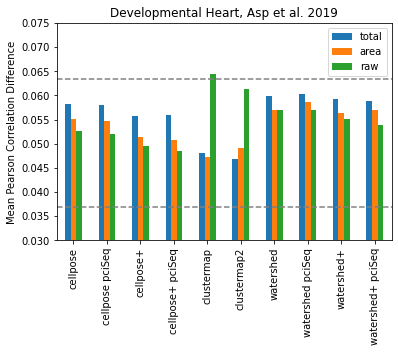

In [4]:
import matplotlib.pyplot as plt

show_metric = 'coex_all_normst'
raw = 'coex_all_rawst'
temp_df = pd.DataFrame(columns=['cellpose', 'cellpose pciSeq', 'cellpose+', 'cellpose+ pciSeq','clustermap', 'clustermap2', 'watershed', 'watershed pciSeq','watershed+', 'watershed+ pciSeq'])
temp_df.loc['total',:] = metric_heart.loc[[show_metric],['total' in e for e in metric_heart.columns]].values
temp_df.loc['area',:] = metric_heart.loc[[show_metric],['area' in e for e in metric_heart.columns]].values
temp_df.loc['raw',:] = metric_heart.loc[[raw],['area' in e for e in metric_heart.columns]].values
temp_df.loc['rand',:] = metric_heart.loc[['rand_all'],['area' in e for e in metric_heart.columns]].values


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel("Mean Pearson Correlation Difference")
ax.set_title("Developmental Heart, Asp et al. 2019")
temp_df.T.loc[:, ['total','area','raw']].plot(kind='bar',ax=ax)
plt.ylim(0.03, 0.075)
plt.axhline(y=np.mean(temp_df.loc['rand',:]), color='0.5', linestyle='--')
plt.axhline(y=coex_all, color='0.5', linestyle='--')
plt.show()

# Presentation Data: Rand Index

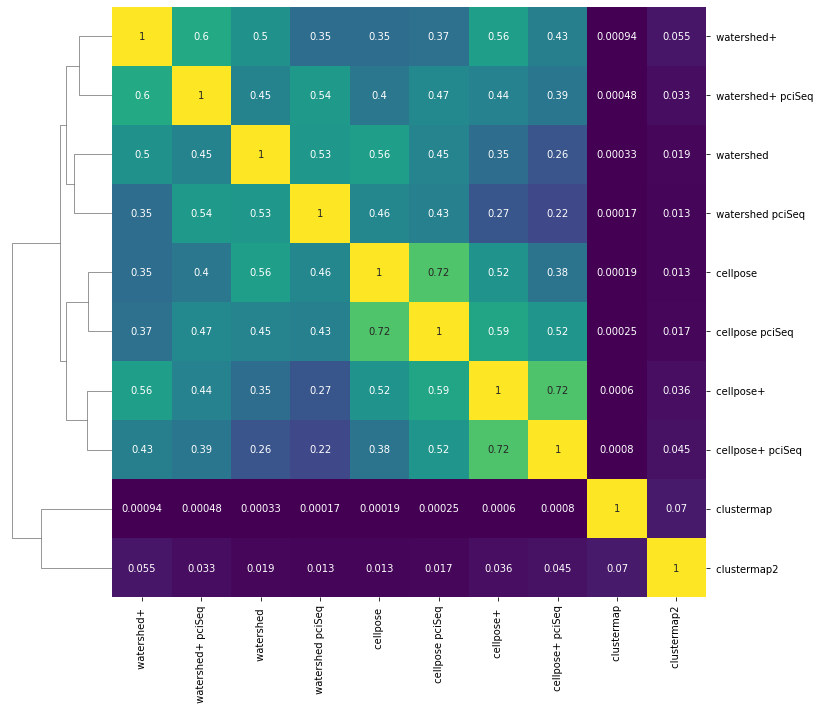

In [5]:
import seaborn as sns
import sklearn.metrics
import numpy as np
import pandas as pd
import os

folder = '/mnt/d/hmgu/data/cluster_run/heart'
assign_list= list( filter(lambda file: 'assignments' in file, os.listdir(folder)))
assign = pd.DataFrame()
for a_file in assign_list:
    path = os.path.join(folder, a_file)
    assignments = pd.read_csv(path)
    a = a_file.replace('assignments', '').removesuffix('.csv')
    assign[a] = (assignments.cell)
    
assign.columns = [' cellpose ', ' cellpose pciSeq', ' cellpose+ ', ' cellpose+ pciSeq',
       ' clustermap', ' clustermap2', ' watershed ', ' watershed pciSeq',
       ' watershed+ ', ' watershed+ pciSeq']

rand_matrix = np.zeros([len(assign.columns), len(assign.columns)])
rand_matrix = pd.DataFrame(rand_matrix)
for i in range(len(assign.columns)):
    for j in range(len(assign.columns)):
        c1 = assign.iloc[:, i]
        c2 = assign.iloc[:, j]
        rand_matrix.iloc[i, j] = sklearn.metrics.adjusted_rand_score(c1,c2)

rand_matrix.columns = assign.columns
rand_matrix.index = assign.columns

sns.clustermap(rand_matrix, cmap='viridis', cbar_pos=None, annot=True, dendrogram_ratio=[0.15, 0], figsize=(11.5,10))

# Experimenting with Rand Index

In [20]:
import pandas as pd
import sklearn.metrics

spots = pd.read_csv('/mnt/d/hmgu/data/cluster_run/hippocampus/assignments_watershed-0_pciSeq-0.csv')
spots2 = pd.read_csv('/mnt/d/hmgu/data/cluster_run/hippocampus/assignments_cellpose-1_pciSeq-0.csv')

#All spots
print("All Spots:")
c1 = spots.cell
c2 = spots2.cell
print(  f"RI:\t{int(sklearn.metrics.rand_score(c1,c2)*1000)/1000}"  )
print(  f"ARI:\t{int(sklearn.metrics.adjusted_rand_score(c1,c2)*1000)/1000}"  )


print("\nSpots in assignment 1:")
c1 = spots.cell[spots.cell != 0]
c2 = spots2.cell[spots.cell != 0]
print(  f"RI:\t{int(sklearn.metrics.rand_score(c1,c2)*1000)/1000}"  )
print(  f"ARI:\t{int(sklearn.metrics.adjusted_rand_score(c1,c2)*1000)/1000}"  )

print("\nSpots in assignment 2:")
c1 = spots.cell[spots2.cell != 0]
c2 = spots2.cell[spots2.cell != 0]
print(  f"RI:\t{int(sklearn.metrics.rand_score(c1,c2)*1000)/1000}"  )
print(  f"ARI:\t{int(sklearn.metrics.adjusted_rand_score(c1,c2)*1000)/1000}"  )

print("\nSpots in both assignments:")
c1 = spots.cell[(spots.cell != 0) & (spots2.cell != 0)]
c2 = spots2.cell[(spots.cell != 0) & (spots2.cell != 0)]
print(  f"RI:\t{int(sklearn.metrics.rand_score(c1,c2)*1000)/1000}"  )
print(  f"ARI:\t{int(sklearn.metrics.adjusted_rand_score(c1,c2)*1000)/1000}"  )


All Spots:
RI:	0.668
ARI:	0.201

Spots in assignment 1:
RI:	0.995
ARI:	0.112

Spots in assignment 2:
RI:	0.747
ARI:	0.0

Spots in both assignments:
RI:	0.999
ARI:	0.743


# Plotting Segments and Spots

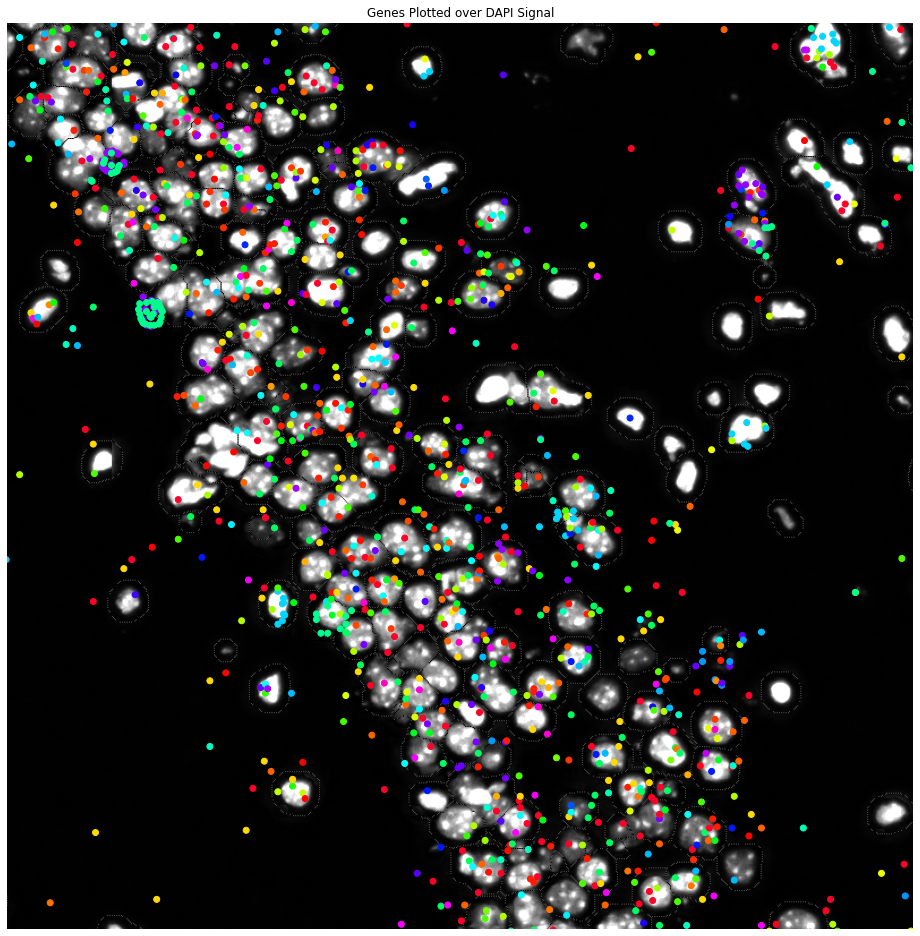

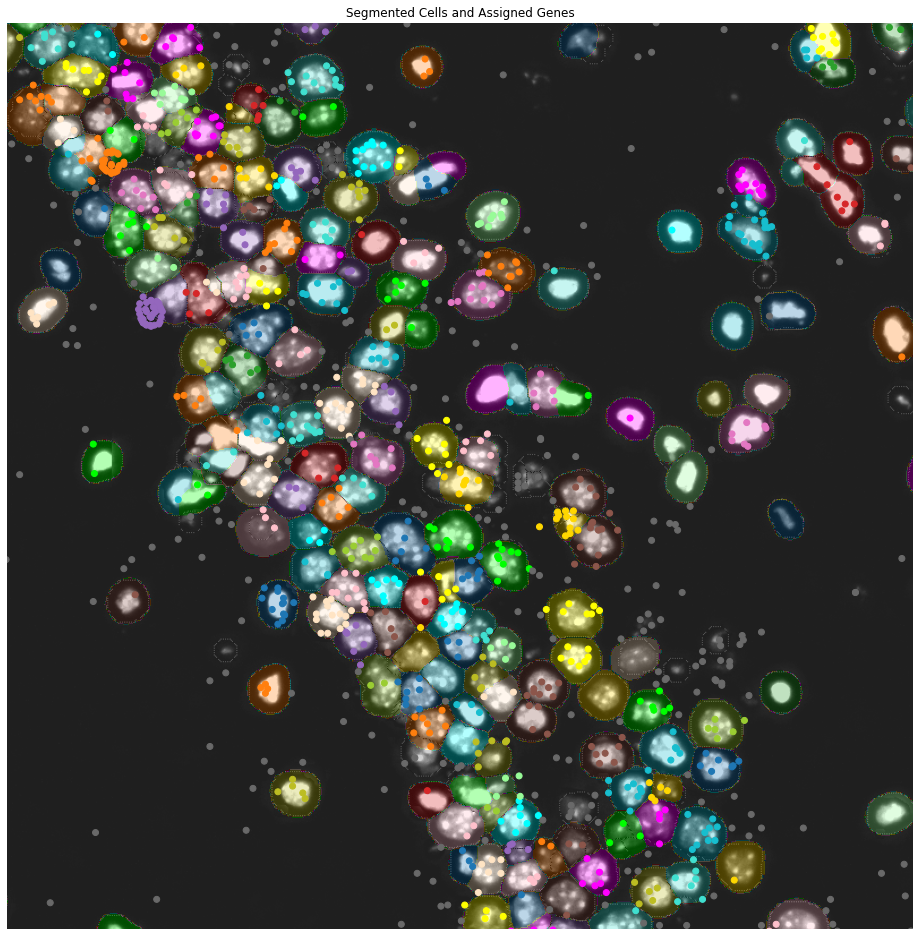

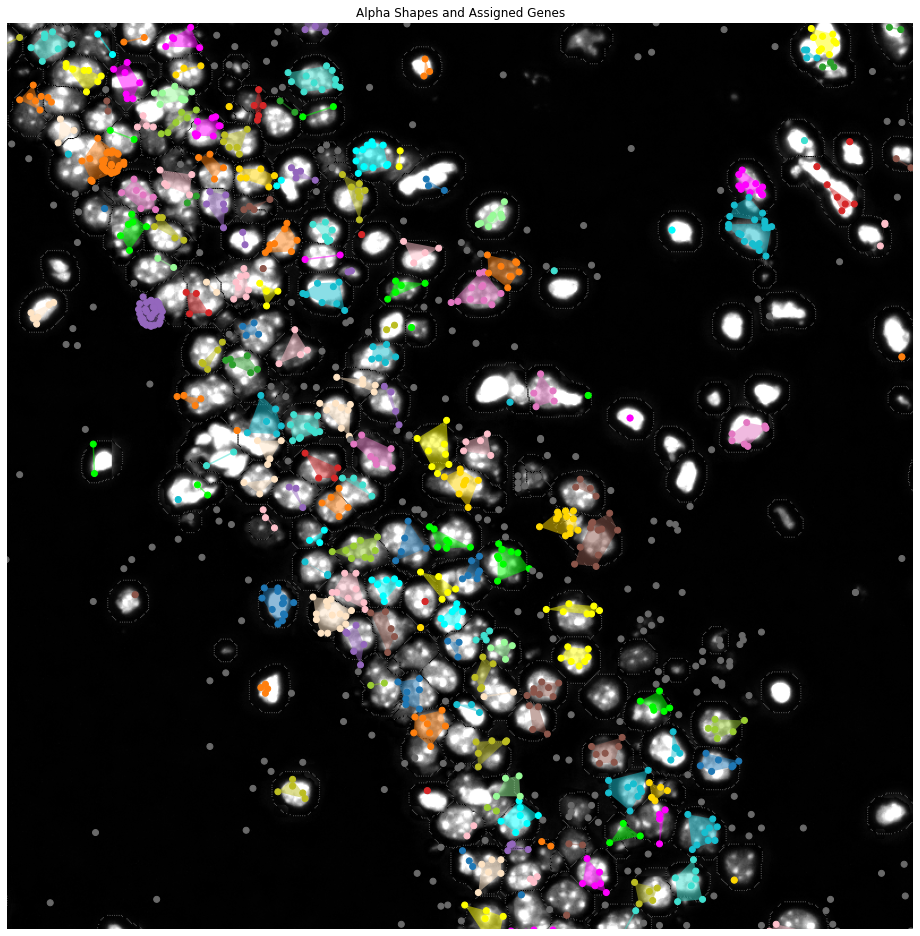

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scanpy as sc
import numpy as np
import pandas as pd
import tifffile

# Set colors for segments 
cmap = mcolors.ListedColormap(colors, N= np.max(spots.cell))
cmap.set_under('dimgray')
colors = list(mcolors.TABLEAU_COLORS)
colors.extend(['lime','turquoise','pink','aqua','magenta','yellow','bisque','gold','palegreen','yellowgreen'])
colors.remove('tab:gray')

#Read files
adata =sc.read('/mnt/d/hmgu/data/cluster_run/hippocampus/counts_cellpose-1_pciSeq-0_area-0.h5ad')
seg_tif = tifffile.imread('/mnt/d/hmgu/data/cluster_run/hippocampus/segments_cellpose-1.tif')
raw = tifffile.imread('/mnt/d/hmgu/data/hippocampus/CA1DapiBoundaries_7-1_right.tif')
spots = pd.read_csv('/mnt/d/hmgu/data/cluster_run/hippocampus/assignments_cellpose-1_pciSeq-0.csv')

#Set dpi and viewing bounds
_dpi = 72
x_coord = 5200
y_coord = 1600
x_coord2 = x_coord+800
y_coord2 = y_coord+800

#-------- figure 1 ------------

#Plot spots based on gene ID
plt.figure(figsize=(1200/_dpi, 1200/_dpi), dpi=_dpi)
plt.imshow(raw, cmap='gray') #DAPI
plt.scatter(spots.x, spots.y, s=_dpi/2, c=spots.Gene.astype('category').cat.codes,cmap='gist_rainbow') #Spots
plt.xlim(x_coord,x_coord2)
plt.ylim(y_coord,y_coord2)
plt.title("Genes Plotted over DAPI Signal")
plt.axis('off')
plt.show()

#-------- figure 2 ------------

#Plots cell segments
plt.figure(figsize=(1200/_dpi, 1200/_dpi), dpi=_dpi)
plt.imshow(raw, cmap='gray') #DAPI
plt.scatter(spots.x, spots.y, s=_dpi/2, c=spots.cell,cmap=cmap, vmin = 0.1) #Spots
plt.imshow(seg_tif, cmap=cmap, alpha = 0.3, vmin = 0.1) #Segments

plt.xlim(x_coord,x_coord2)
plt.ylim(y_coord,y_coord2)
plt.title("Segmented Cells and Assigned Genes")
plt.axis('off')
plt.show()

#-------- figure 3 ------------

plt.figure(figsize=(1200/_dpi, 1200/_dpi), dpi=_dpi)
plt.imshow(raw, cmap='gray') #DAPI
plt.scatter(spots.x, spots.y, s=_dpi/2, c=spots.cell,cmap=cmap, vmin = 0.1) #Spots

#Plot alpha_shapes
import json
import shapely
import geopandas
p = adata.obs['alpha_shape'].apply(json.loads)
p = p.apply(shapely.geometry.shape)
p = geopandas.GeoSeries(p)
ax = plt.subplot()
p.plot(ax=ax,alpha = 0.5, color=cmap((adata.obs['cell_id']-1)/np.max(spots.cell)))

plt.xlim(x_coord,x_coord2)
plt.ylim(y_coord,y_coord2)
plt.title("Alpha Shapes and Assigned Genes")
plt.axis('off')
plt.show()

# Comparing assignments

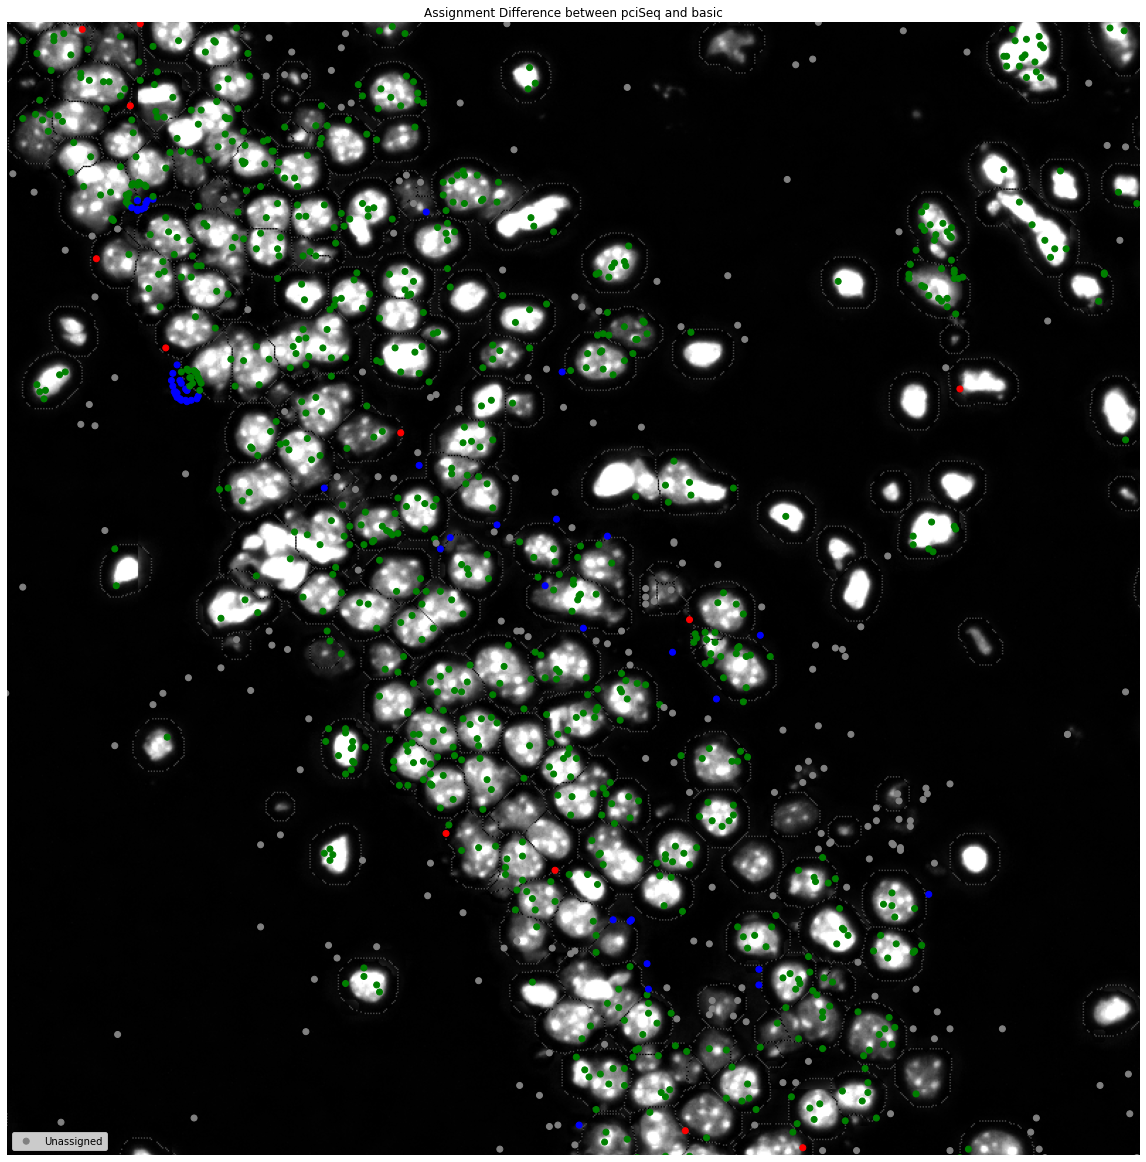

count
pciSeq     657
neither   5448
both     12569
basic      358

In [63]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import tifffile

raw = tifffile.imread('/mnt/d/hmgu/data/hippocampus/CA1DapiBoundaries_7-1_right.tif')
spots = pd.read_csv('/mnt/d/hmgu/data/cluster_run/hippocampus/assignments_cellpose-1_basic-0.csv')
spots2 = pd.read_csv('/mnt/d/hmgu/data/cluster_run/hippocampus/assignments_cellpose-1_pciSeq-0.csv')
names = ['basic', 'pciSeq']


#Set dpi and viewing bounds
_dpi = 72
x_coord = 5200
y_coord = 1600
x_coord2 = x_coord+800
y_coord2 = y_coord+800

fig = plt.figure(figsize=(1500/_dpi, 1500/_dpi), dpi=_dpi)
ax = fig.add_subplot(111)

imgplot = plt.imshow(raw, cmap = 'gray')# DAPI
color = pd.Series(['gray'] * len(spots), dtype=str)# Unassigned = gray
color[spots.cell>0] = 'red'#In first spot only
color[spots2.cell>0] = 'blue'#In second spot only
color[(spots.cell>0)&(spots2.cell>0)] = 'green'#Both
ax.scatter(spots.x, spots.y, s=_dpi/2, c=color.astype('category'))

plt.xlim(x_coord,x_coord2)
plt.ylim(y_coord,y_coord2)
plt.axis('off')
plt.title("Assignment Difference between pciSeq and basic")
#I dont know how legends work in matplotlib :(
plt.legend(["Unassigned", f"{names[0]} only", f"{names[1]} only","Assigned by both"])
plt.show()

df = pd.DataFrame(np.asarray(np.unique(color, return_counts=True) )[1], 
             index=np.asarray(np.unique(color, return_counts=True) )[0],
            columns=['count']).rename(index={'blue': names[1], 'gray': 'neither', 'red': names[0], 'green': 'both' })
df

# Alpha Area Example

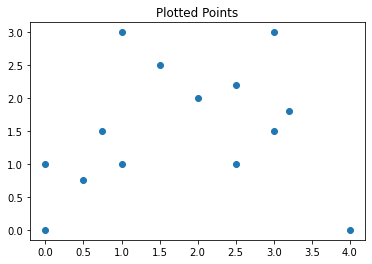

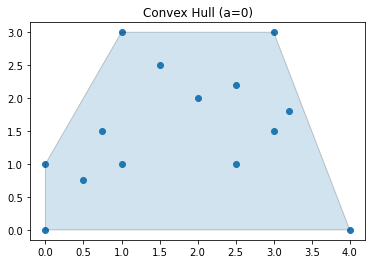

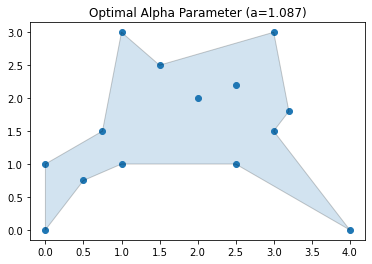

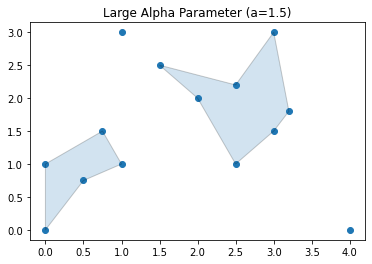

In [7]:
import matplotlib.pyplot as plt
import alphashape
from descartes import PolygonPatch

points = [(0,0), (0,1), (1,3), (2,2), (1,1), (4,0),(3,3),
          (3.2,1.8), (0.75,1.5) ,(2.5,2.2), (3,1.5), (1.5,2.5), (2.5,1), (0.5,0.75),
         ]

fig, ax = plt.subplots()
ax.scatter(*zip(*points))
plt.title("Plotted Points")
plt.show()

alpha_shape = alphashape.alphashape(points,0)
fig, ax = plt.subplots()
ax.scatter(*zip(*points))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.title("Convex Hull (a=0)")
plt.show()

opt_alpha = alphashape.optimizealpha(points, max_iterations=100, lower = 0, upper = 5)
alpha_shape = alphashape.alphashape(points, opt_alpha)
fig, ax = plt.subplots()
ax.scatter(*zip(*points))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.title(f"Optimal Alpha Parameter (a={int(opt_alpha*1000)/1000})")
plt.show()

alpha_shape = alphashape.alphashape(points,1.5)
fig, ax = plt.subplots()
ax.scatter(*zip(*points))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.title("Large Alpha Parameter (a=1.5)")
plt.show()